### Подбор параметров кластеризации и выбор алгоритмов. 
1. Рассмотрены 6 различных алгоритмов кластеризации. Для трёх из них нет необходимости в подборе гиперпараметров.
2. Построены графики зависмости гиперпараметров алгоритмов кластеризации от произведения средних по коэффициентам качества кластеризации. На **старых** модельных данных.
3. Построены гистограммы коэффициентов качества кластеризации.  

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
import datetime
import math
import warnings 
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)


from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px
le = LabelEncoder()

D:\Anaconda\envs\myenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\Anaconda\envs\myenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import custom_functions as cf

D:\Anaconda\envs\myenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\Anaconda\envs\myenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# параметры графики

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)  #> 3.0.0
print(sns.__version__) 

3.3.2
0.11.0


In [ ]:
# Старый модельный банк.
# olddata = pd.read_csv('datachanged/AllMc0COld', sep = '\t')

In [4]:
# Старый модельный банк.
# Скачиваем обработанные данные. В них нет малениких и малоэнергичных семейств.
data = pd.read_csv('datachanged/AllMc0C')
data = data.drop(['Unnamed: 0'], axis = 1).copy()
AllMc0 = data[[' num_of_family', ' j', 'X(J)', 'Y(J)', 'E(J)', 'H(J)', 'A0', 'ER']].copy()

In [5]:
# Содержит коэффициенты результатов кластеризации физиков (более ранняя).
data2 = pd.read_csv('data/outBC_coef.txt', sep=',')
# Обрезается некорректная часть данных, выявленная при проверке (файл allfamilies)
data2 = data2.loc[data2[data2.columns[0]]<1299].copy()
data2 = data2.drop_duplicates().copy()

In [6]:
# Проверяем, что у нас коэффициенты только для тех семецств, которые мы будем кластеризовать. Мы ведь убрали маленькие.
x = list(set(data[' num_of_family']))
y = list(set(data2[' num_of_family']))
for i in y:
    if i not in x:
        data2 = data2[data2[' num_of_family'] !=i].copy()

In [7]:
data2.head(10)

,num_of_family,EF1,EF2,EF3,EF4
0,1,0.666667,1.000000,0.857143,0.680555
6,2,0.833333,1.000000,0.714286,0.600000
11,3,0.783951,0.888889,0.666667,0.777778
20,4,0.857143,0.428571,0.500000,0.428571
27,5,1.000000,0.500000,2.000000,0.250000
31,6,0.712554,0.857143,0.666667,0.709360
38,7,0.829545,1.000000,1.333333,0.604545
42,8,0.785714,1.000000,0.714286,0.950000
47,9,0.763889,0.666667,0.800000,0.458333
53,10,0.697917,0.875000,0.538462,0.733745


Функции для построение графиков 2д и 3д

In [8]:
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator


def Create_px_plot(OneFamily, i, st, agl, db, op, old, values):
    '''
     Визуализирует 2d график конкретного семейства i вместе с полученным для него коэффицентами качества кластеризации 
     алгоритмов aglomerative, dbscan, meanshift, old при указанных гиперпараметрах values. 
     
     Входные значения:
     OneFamily - датафрейм семейства.
     i - номер семейства.
     st - тип частицы: MgSi, Proton, Ferrum, All.
     agl - коэффициенты качества аггломератиыной кластеризации.
     db - коэффициенты качества кластеризации dbscan.
     op - коэффициенты качества кластеризации optics.
     old - коэффициенты качества кластеризации алгоритма Памир. 
     values - параметры, которые использовались при кластеризации.
     
     Возвращаемые значение:
     fig - 2d фигура графика.
    '''
    
    OneFamily["H(J)"] = OneFamily["H(J)"].astype(float).round(3)
    n = len(set(OneFamily["H(J)"]))
    
    
    OneFamily["H(J)"] = OneFamily["H(J)"].astype(str)
    #OneFamily["cluster"] = OneFamily["cluster"].astype(int)
    
    
    title_name = f'Clusters in {i} where {st}'
    #title_name = f'Clusters in {i} where {st}_{values}' 
    
    legend_name = f'coef Purit Split Int Effic <br> agl {agl} <br> db {db} <br> op {op}  <br> pr {old} <br> <br> H(J) ({n})'
    

    fig = px.scatter(OneFamily, x="X(J)", y="Y(J)", size="E(J)",   
                     color="H(J)", hover_name="H(J)", hover_data =['cluster'], opacity = 0.85)

#     raw_symbols = SymbolValidator().values
#     sym = list(np.random.choice( raw_symbols , len(OneFamily) ) )
#     fig = px.scatter(OneFamily, x="X(J)", y="Y(J)", size="E(J)",   
#                       color="H(J)", symbol = 'cluster', hover_name="H(J)", symbol_sequence = sym )
    
    
    fig.update_layout(
        title=title_name,
        title_font_size= 16 ,
        legend_title=legend_name,
        plot_bgcolor = 'white',
        paper_bgcolor = 'whitesmoke',
        font=dict(
            family='Verdana',
            size=12,
            color='black'
        ))
    
    fig.write_image(f"images/web/clustered/2d_clustered_{i}_{st}_{values}.png")
    fig.write_html(f"web/clustered/2d_clustered_{i}_{st}_{values}.html")
    
    return fig

In [9]:
import plotly.express as px

def Create_3d_plot(OneFamily, i, st, agl, db, op, old, values):
    '''
     Визуализирует 3d график конкретного семейства i вместе с полученным для него коэффицентами качества кластеризации 
     алгоритмов aglomerative, dbscan, meanshift, old при указанных гиперпараметрах values. 
     
     Входные значения:
     OneFamily - датафрейм семейства.
     i - номер семейства.
     st - тип частицы: MgSi, Proton, Ferrum, All.
     agl - коэффициенты качества аггломератиыной кластеризации.
     db - коэффициенты качества кластеризации dbscan.
     op - коэффициенты качества кластеризации optics.
     old - коэффициенты качества кластеризации алгоритма Памир. 
     values - параметры, которые использовались при кластеризации.
     
     Возвращаемые значение:
     fig - 2d фигура графика.
    '''
    OneFamily["H(J)"] = OneFamily["H(J)"].astype(float).round(3)
    n = len(set(OneFamily["H(J)"]))
    
    #OneFamily["H(J)"] = OneFamily["H(J)"].astype(str)
    OneFamily["cluster"] = OneFamily["cluster"].astype(str)
    
    title_name = f'Clusters in {i} where {st} {values}' 
    legend_name = f'coef Purit Split Int Effic <br> agl {agl} <br> db {db} <br> op {op}  <br> pr {old} <br> <br> H(J) ({n})'
    
    fig = px.scatter_3d(OneFamily, x='X(J)', y='Y(J)', z='H(J)', color='cluster', size = 'E(J)',
                        hover_data=["H(J)", "E(J)", "labels"], opacity = 0.85 )
    
    fig.update_layout(
        title=title_name,
        title_font_size= 16 ,
        legend_title=legend_name )
    
    fig.write_image(f"images/web/clustered/3d_clustered_{i}_{st}_{values}.png")
    fig.write_html(f"web/clustered/3d_clustered_{i}_{st}_{values}.html")
    
    return fig

Поделим всю модель на семейства по типам частиц. Возьмем из каждого по 10 частиц.

In [10]:
proton = AllMc0[AllMc0['A0'] == 1].copy() # протоны
ferrum = AllMc0[AllMc0['A0'] == 9].copy() # железо
CNO = AllMc0[(AllMc0['A0']>=6)&(AllMc0['A0'] <= 8)].copy() # CNO которое на самом деле MgSi

In [11]:
# Создание листов с номерами 10 семейств
NumP = list(set(proton[ ' num_of_family']))[:10]
NumF = list(set(ferrum[ ' num_of_family']))[:10]
NumC = list(set(CNO[ ' num_of_family']))[:10]

Сделаем пробную кластеризацию

Физические коэффициенты точности:

EF1) purity  = число частиц в кластере, имеющих самую популярную высоту в этом кластере/ число частиц в кластере
Затем = Summa {P_i}/N_c, где N_c - число частиц в семействе

EF2) splitting = число самых популярных высот по всем кластерам / число кластеров в семействе

EF3) integrity (E->S) = число популярных высот, выделенных в каждом кластере /число уникальных высот в семействе

EF4) Efficiency (F->E) = число частиц в кластере, имеющих самую популярную высоту в этом кластере/число частиц в семействе, имеющих эту же высоту
Затем = Summa {F_i}/N_c, где N_c - число частиц в семействе


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
import hdbscan

In [13]:
def noise_cluster(labels):
    """Убирает шумовые точки, обозначая их отдельными кластерами."""
    if -1 not in labels:
        return labels
    
    coef = len(set(labels))-1
    for i in range(len(labels)):  
        if labels[i] == -1:
            coef+=1
            labels[i] = labels[i]+coef
    return labels

In [15]:
def ClusteringAGLCLUST(eps, X):
    clustering = AgglomerativeClustering(n_clusters=None, affinity = 'precomputed', distance_threshold = eps, linkage = 'average').fit(X)
    labels = clustering.labels_    
    return labels

In [16]:
def ClusteringDBSCAN(eps, X):
    db = DBSCAN(eps=eps, min_samples = 1).fit(X)
    labels = db.labels_
    return noise_cluster(labels)

In [17]:
def ClusteringMeanShift(eps, X):
    clustering = MeanShift(bandwidth=eps).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [18]:
def ClusteringOptics(eps, X):
    clustering = OPTICS(min_samples = 2).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [19]:
def ClusteringHdbscan(eps, X):
    clustering = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True, 
                            gen_min_span_tree=False, leaf_size=1, min_cluster_size=2, min_samples=None, p=None).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [20]:
def ClusteringAffinity(eps, X):
    clustering = AffinityPropagation(damping = eps, random_state=5).fit(X)
    labels = clustering.labels_
    return noise_cluster(labels)

In [21]:
# Функция подсчета значений коэффициентов

def CoefPFI(OneFamily, num):
    """
    Возвращает значения коэффициентов качества кластеризации.
    
    Входные значения:
    OneFamily - датафрейм. 
    num - номер семейства.
    
    Возвращаемые значение:
    result - список коэффициентов в следующем порядке:
    num, purity, splitting, integrity, efficiency, mean, var, compose
    
    (номер семейства, чистота, фрагментарность, целостность, эффективность,
    среднее, дисперсия, произведение средних).
    """
    P = 0
    E = 0
    DomH = [] #доминирующие высоты в кластерах
    N_c = len(OneFamily)
    
    labels = OneFamily['cluster']
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    for i in range(n_clusters_):
        value = OneFamily[OneFamily['cluster']==i]['labels'].value_counts()
        n_d = value[:1].values
        n_c = len(OneFamily[OneFamily['cluster']==i]['cluster'])
        P_i = n_d[0]/n_c
        P = P + P_i
        
        x = value[:1].index[0]
        n_t = len(OneFamily[OneFamily['labels']==x])
        E_i = n_d[0]/n_t
        E = E + E_i
        
        DomH.append(x)
    
    purity = P/n_clusters_ #1
    
    splitting = len(set(DomH))/n_clusters_ #2
    
    integrity = len(set(DomH))/len(set(OneFamily['labels'])) #3
    
    efficiency =  E/n_clusters_ #4
    
    result = [num, purity, splitting, integrity, efficiency] 
    
    mean = np.mean(result[1:])
    var = np.var(result[1:])
    compose = (purity+efficiency)*(integrity+splitting)/4
    
    result = result + [mean]
    result = result + [var]
    result = result + [compose]
    
    return result

Проверка на одном семействе 518

In [22]:
def result_write(result):
    """
    Выводит коэффициенты качества кластеризации в виде датафрейма.
    
    Входные значения:
    result - знаяения коэффициентов.
    """
    result_dict = {}
    names = ['num_of_family', 'purity', 'splitting', 'integrity', 'efficiency', 'mean', 'var', 'compose']
    return pd.DataFrame([result], columns = names).round(3)

In [23]:
etalon = 518
i = 518
OneFamily = AllMc0[AllMc0[' num_of_family']==i].copy()
labels = LabelEncoder().fit_transform(OneFamily['H(J)'])
OneFamily['labels'] = labels

In [24]:
X = cf.matrix_of_distance(OneFamily['X(J)'].values, OneFamily['Y(J)'].values, OneFamily['E(J)'].values, 2)

In [25]:
eps = np.percentile(OneFamily['ER'], 50)
OneFamily['cluster'] = ClusteringAGLCLUST(eps, X)
dataAgl = CoefPFI(OneFamily, i)
result_write(dataAgl)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,0.767,1.0,0.714,0.9,0.845,0.013,0.714


In [26]:
eps = np.percentile(OneFamily['ER'], 98)
OneFamily['cluster'] = ClusteringDBSCAN(eps, X)
dataDb = CoefPFI(OneFamily, i)
result_write(dataDb)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,0.9,0.667,0.571,0.667,0.701,0.015,0.485


In [27]:
eps = np.percentile(OneFamily['ER'], 98)
OneFamily['cluster'] = ClusteringMeanShift(eps, X)
dataMS = CoefPFI(OneFamily, i)
result_write(dataMS)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,0.9,0.667,0.571,0.667,0.701,0.015,0.485


In [28]:
OneFamily['cluster'] = ClusteringOptics(eps, X)
dataOp = CoefPFI(OneFamily, i)
result_write(dataOp)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,0.938,0.75,0.857,0.75,0.824,0.006,0.678


In [29]:
OneFamily['cluster'] = ClusteringHdbscan(eps, X)
dataHd = CoefPFI(OneFamily, i)
result_write(dataHd)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,1.0,0.7,1.0,0.7,0.85,0.023,0.722


In [39]:
OneFamily['cluster'] = ClusteringAffinity(0.9, X)
dataAf = CoefPFI(OneFamily, i)
result_write(dataAf)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,0.643,1.0,0.286,1.0,0.732,0.088,0.528


In [36]:
OneFamily['cluster'] = cf.PamirAlgorithm(OneFamily)
dataPam = CoefPFI(OneFamily, i)
result_write(dataPam)

,num_of_family,purity,splitting,integrity,efficiency,mean,var,compose
0,518,0.857,0.714,0.714,0.714,0.75,0.004,0.561


In [34]:
agl = np.around(dataAgl[1:-1], 2)
db = np.around(dataDb[1:-1], 2)
ms = np.around(dataMS[1:-1], 2)
op = np.around(dataOp[1:-1], 2)
hd = np.around(dataHd[1:-1], 2)
af = np.around(dataAf[1:-1], 2)

x = data2.loc[data2[data2.columns[0]]==i].head(1).values[0]
mean = x[1:].mean()
var = np.var(x[1:])
data = list(x) + [mean] + [var] 

old = np.around(data[1:-1], 2)

In [33]:
col = ['Name', 'num_of_fam', 'P', 'S', 'I', 'E', 'M', 'V', 'C']

Agl = ['aglclust'] + dataAgl
Db = ['dbscan'] + dataDb
MS = ['MeanShift'] + dataMS
Op = ['Optics'] + dataOp
Hd = ['hdbscan'] + dataHd
Af = ['affinity'] + dataAf

# x = data2.loc[data2[data2.columns[0]]==i].head(1).values[0]
# mean = x[1:].mean()
# var = np.var(x[1:])
# compose = (x[1]+x[4])*(x[2]+x[3])/4
# data = list(x) + [mean] + [var] + [compose]
# Old = ['previous']+ data

Old = ['previous']+ dataPam

all_data = [Agl, Db, MS, Op, Hd, Af, Old]

new_df = pd.DataFrame(data = all_data, columns = col)
new_df = new_df.round(3)

In [34]:
# M - среднее, V - дисперсия коэффициентов PSIE
new_df.sort_values(by = 'C', ascending = False)

,Name,num_of_fam,P,S,I,E,M,V,C
4,hdbscan,518.0,1.000,0.700,1.000,0.700,0.850,0.023,0.722
0,aglclust,518.0,0.767,1.000,0.714,0.900,0.845,0.013,0.714
3,Optics,518.0,0.938,0.750,0.857,0.750,0.824,0.006,0.678
6,previous,518.0,0.857,0.857,0.750,0.810,0.818,0.002,0.670
1,dbscan,518.0,0.900,0.667,0.571,0.667,0.701,0.015,0.485
2,MeanShift,518.0,0.900,0.667,0.571,0.667,0.701,0.015,0.485
5,affinity,518.0,0.683,0.750,0.429,0.750,0.653,0.018,0.422


Построим все наши графики вместе с коэффициентами кластеризации.

In [46]:
# Рисуем и сохраняем выбранные 10 семейств.
def Print_G(data, num, st, val):    
    """
    Кластеризует выбранные семейства со значениями параметра из val. 
    Сохраняет кластеризованные графики выбранных семейств при помощи функций, которые рисуют графики.
    
    Входные значения:
    data - датафрейм с несколькими семействами, 
    num - список номеров семейств из датафрейма, 
    st - тип частицы (протон или железо или др.), 
    val - параметры для кластеризации.
    
    """
    
    for i in num:
        print(i)
        # Выбираем семейство и перекодируем высоты для удобства
        df = data[data[' num_of_family']==i].copy()
        labels = LabelEncoder().fit_transform(df['H(J)'])
        df['labels'] = labels
        # Строим матрицу расстояний со вторым коэффициентом расстояния
        X = cf.matrix_of_distance(df['X(J)'].values, df['Y(J)'].values, df['E(J)'].values, 2)
        
        H = len(set(labels))
        
        #Dbscan
        eps = np.percentile(df['ER'], val[1])
        df['cluster'] = ClusteringDBSCAN(eps, X)
        dataDb = CoefPFI(df, i)
        
        #Optics
        eps = np.percentile(df['ER'], val[2])
        df['cluster'] = ClusteringOptics(eps, X)
        dataOp = CoefPFI(df, i)
        
        #Аггломеративная кластеризация
        eps = np.percentile(df['ER'], val[0])
        df['cluster'] = ClusteringAGLCLUST(eps, X)
        dataAgl = CoefPFI(df, i)
        
        #Также находим предыдущие значения с алгоритмом ранее. 
        
        df['cluster'] = cf.PamirAlgorithm(df)
        dataPam = CoefPFI(OneFamily, i)
        
#         x = list(data2.loc[data2[data2.columns[0]]==i].head(1).values[0])
#         x = x + [(x[1]+x[4])*(x[2]+x[3])/4]
#         old = np.around(x[1:], 2)
#         print(x)
        
        index = [1, 2, 3, 4, 7]
        agl = np.around([dataAgl[i] for i in index], 2)
        db = np.around([dataDb[i] for i in index], 2)
        op = np.around([dataOp[i] for i in index], 2)
        old = np.around([dataPam[i] for i in index], 2)

        
        Create_px_plot(df, i, st, agl, db, op, old, str(val))
        Create_3d_plot(df, i, st, agl, db, op, old, str(val))

In [47]:
val_p = [60, 100, 100]
val_f = [5, 50, 50]
val_c = [15, 80, 80]
val_all = [50, 95, 95]

In [48]:
Print_G(proton, NumP[:1], 'Proton', val_p)

1
+
++


In [82]:
Print_G(ferrum, NumF[:1], 'Fer', val_f)

128


In [83]:
Print_G(CNO, NumC[:1], 'MgSi', val_c)

261


In [33]:
num_all = AllMc0[' num_of_family'].unique()
random_index = np.random.choice(num_all.size, 2, replace=False) 
num_sample = num_all[random_index]
print([num_sample[i] for i in range(num_sample.size)])

[853, 1111]


In [34]:
num_sample = [853, 759]
df_sample = AllMc0[AllMc0[' num_of_family'].isin(num_sample)].copy()

In [35]:
Print_G(df_sample, num_sample, 'All', val_all)

853
[853.0, 0.7635126999999999, 0.9285714, 0.5909091, 0.6794872, 0.5481525523879874]
759
[759.0, 0.7833334, 1.0, 0.7142857, 0.9, 0.721428593988095]


Теперь посчитаем коэффициенты для всех семейств без построения картинок.

In [108]:
def Create_All_2(data, data2, family_name, values):
    """
    Кластеризует семейство и усредняет по значениям коэффициента (P+E)*(I+S)/4.
    (требует ускорения).
    
    Входные значения:
    data - данные для кластеризации, 
    data2 - данные, которые содержат коэффициенты предыдущей кластеризации (не используем), 
    family_name - тип частицы протон, железо или др., 
    values - параметры для подбора eps - ограничения кластеризации.
    
    Выходные значения:
    Датафрейм следующего формата
    параметры - тип семейства - алгоритм - среднее коэффициентов по всем семействам.
    """
    
    Num = list(set(data[' num_of_family']))
    
    Old = []
    Agl = []
    Db = []
    MS = []
    Op = []
    Hd = []
    Af = []
    all_data = []
    
    label = 1 # достаточно посчитать один раз
    
    col = ['values', 'family', 'name', 'P', 'S', 'I', 'E', 'M', 'V', 'C']
    
    
    for val in values:
        
        print(val, datetime.datetime.now()) 
        
        for i in Num:
            # print(i)
            
            # Выбираем семейство и перекодируем высоты для удобства
            df = data[data[' num_of_family']==i].copy()            
            labels = le.fit_transform(df['H(J)'])
            df['labels'] = labels
            
            # Строим матрицу расстояний со вторым коэффициентом расстояния
            X = cf.matrix_of_distance(df['X(J)'].values, df['Y(J)'].values, df['E(J)'].values, 2)
            
            if label:
                #print('pamir')
                df['cluster'] = cf.PamirAlgorithm(df)
                dataPam = CoefPFI(df, i)
                Old.append(dataPam[1:])
                
#                 x = data2.loc[data2[data2.columns[0]]==i].head(1).values[0]
#                 mean = x[1:].mean()
#                 var = np.var(x[1:])
#                 compose = (x[1]+x[4])*(x[2]+x[3])/4
#                 dataOld = list(x)[1:] + [mean] + [var] + [compose]
#                 Old.append(dataOld)
        
            
            if i%200==0:
                print(i)

            #Аггломеративная кластеризация
            #print('aggl')
            eps = np.percentile(df['ER'], val[0])
            df['cluster'] = ClusteringAGLCLUST(eps, X)
            dataAgl = CoefPFI(df, i)
            #Dbscan
            #print('dbscan')
            eps = np.percentile(df['ER'], val[0])
            df['cluster'] = ClusteringDBSCAN(eps, X)
            dataDb = CoefPFI(df, i)
            #MeanShift
            #print('meanshift')
            eps = np.percentile(df['ER'], val[0])
            df['cluster'] = ClusteringMeanShift(eps, X)
            dataMs = CoefPFI(df, i)
                
            #hdbscan
            #print('hdbscan')
            df['cluster'] = ClusteringHdbscan(eps, X)
            dataHd = CoefPFI(df, i)                
                 
            #Affinity 
            #print('affinity')
            df['cluster'] = ClusteringAffinity(0.9, X)    
            dataAf = CoefPFI(df, i)

            #Optics
            #print('optics')
            df['cluster'] = ClusteringOptics(eps, X)
            dataOp = CoefPFI(df, i)
                
            Hd.append(dataHd[1:])
            Af.append(dataAf[1:])
            Op.append(dataOp[1:])
                
            Agl.append(dataAgl[1:])
            Db.append(dataDb[1:])
            MS.append(dataMs[1:])
                   
    
        
        Old_new = [str(val)] + [''] + ['pamir'] + list(np.mean(Old, axis = 0))  
        
        Agl = [str(val)] + [family_name] + ['aglclust'] + list(np.mean(Agl, axis = 0))
        Db = [str(val)] + [''] + ['dbscan'] + list(np.mean(Db, axis = 0))
        MS = [str(val)] + [''] + ['MeanShift'] + list(np.mean(MS, axis = 0)) 
        Op = [str(val)] + [''] + ['Optics'] + list(np.mean(Op, axis = 0))            
        Hd = [str(val)] + [''] + ['Hdbscan'] + list(np.mean(Hd, axis = 0))
        Af = [str(val)] + [''] + ['Affinity'] + list(np.mean(Af, axis = 0))


        all_data = all_data + [Old_new, Agl, Db, MS, Op, Hd, Af]
        Agl = []
        Db = []
        MS = []
        Op = []
        Hd = []
        Af = []
        
        # После первого прохода меняем значения флага, для алгоритмов параметры подбирать не нужно.
        label = 0
    
    new_df = pd.DataFrame(data = all_data, columns = col)
    new_df = new_df.round(3)
    
    return new_df       

In [106]:
# Выбор значения кластеризации перебором параметров
values = [[i]*3 for i in range(0, 105, 5)]

In [65]:
#part1 = Create_All_2(proton, data2, 'Proton', values)

In [50]:
#part2 = Create_All_2(ferrum, data2, 'Ferrum', values)

In [51]:
#part3 = Create_All_2(CNO, data2, 'MgSi', values)

In [ ]:
# Сохраняем значения коэффициентов.
# part1.to_csv('datachanged/1_proton_val')
# part2.to_csv('datachanged/1_ferrum_val')
# part3.to_csv('datachanged/1_mgsi_val')

In [ ]:
# part1 = pd.read_csv('datachanged/1_proton_val')
# part2 = pd.read_csv('datachanged/1_ferrum_val')
# part3 = pd.read_csv('datachanged/1_mgsi_val')

In [107]:
part4 = Create_All_2(AllMc0, data2, 'All', values)

[0, 0, 0] 2022-03-16 22:17:51.563316
200
400
600
800
1000
1200
[5, 5, 5] 2022-03-16 22:27:24.713349
200
400
600
800
1000
1200
[10, 10, 10] 2022-03-16 22:34:55.704978
200
400
600
800
1000
1200
[15, 15, 15] 2022-03-16 22:42:37.870733
200
400
600
800
1000
1200
[20, 20, 20] 2022-03-16 22:49:57.086571
200
400
600
800
1000
1200
[25, 25, 25] 2022-03-16 22:57:39.249121
200
400
600
800
1000
1200
[30, 30, 30] 2022-03-16 23:04:43.691774
200
400
600
800
1000
1200
[35, 35, 35] 2022-03-16 23:12:08.801235
200
400
600
800
1000
1200
[40, 40, 40] 2022-03-16 23:19:29.996290
200
400
600
800
1000
1200
[45, 45, 45] 2022-03-16 23:26:10.636991
200
400
600
800
1000
1200
[50, 50, 50] 2022-03-16 23:32:37.463660
200
400
600
800
1000
1200
[55, 55, 55] 2022-03-16 23:38:49.844851
200
400
600
800
1000
1200
[60, 60, 60] 2022-03-16 23:44:55.479056
200
400
600
800
1000
1200
[65, 65, 65] 2022-03-16 23:50:52.962803
200
400
600
800
1000
1200
[70, 70, 70] 2022-03-16 23:56:42.934512
200
400
600
800
1000
1200
[75, 75, 75] 202

In [110]:
part4.head()

,values,family,name,P,S,I,E,M,V,C
0,"[0, 0, 0]",,pamir,0.800,0.910,0.633,0.879,0.806,0.027,0.663
1,"[0, 0, 0]",All,aglclust,0.981,0.599,0.970,0.592,0.785,0.054,0.632
2,"[0, 0, 0]",,dbscan,0.998,0.406,0.997,0.405,0.702,0.099,0.503
3,"[0, 0, 0]",,MeanShift,0.998,0.404,0.997,0.403,0.701,0.100,0.501
4,"[0, 0, 0]",,Optics,0.881,0.565,0.781,0.537,0.691,0.054,0.489


In [ ]:
# part4.to_csv('datachanged/1_all_val')

In [109]:
# part4.to_csv('datachanged/1_all_val_last')

In [57]:
# Выгружаем значения коэффициентов.
part4 = pd.read_csv('datachanged/1_all_val_last')

In [139]:
def Difference_values(part_family, family_name):
    """ 
    Строит графики зависимости значения параметра от метрики (подбор гиперпараметра).
    
    Входные значения:
    part_family - датафрейм, в котором содержатся значения коэффициентов по семмействам.
    family_name - имя частицы для отображения в заголовке. 
    
    Возвращает:
    fig - фигура графика.
    """
    fig = go.Figure()
    part = part_family[part_family['name'] == 'pamir']
    fig.add_trace(go.Scatter(x = part['values'], y = part['C'], name = 'pamir' ))

    part = part_family[part_family['name'] == 'aglclust']
    fig.add_trace(go.Scatter(x = part['values'], y = part['C'], name = 'aglust' ))

    part = part_family[part_family['name'] == 'dbscan']
    fig.add_trace(go.Scatter(x = part['values'], y= part['C'], name = 'dbscan' ))

    part = part_family[part_family['name'] == 'MeanShift']
    fig.add_trace(go.Scatter(x = part['values'], y= part['C'], name = 'MeanShift' ))
    
    part = part_family[part_family['name'] == 'Optics']
    fig.add_trace(go.Scatter(x = part['values'], y= part['C'], name = 'Optics' ))
    
    part = part_family[part_family['name'] == 'Hdbscan']
    fig.add_trace(go.Scatter(x = part['values'], y= part['C'], name = 'Hdbscan' ))
    
    part = part_family[part_family['name'] == 'Affinity']
    fig.add_trace(go.Scatter(x = part['values'], y= part['C'], name = 'Affinity' ))

    fig.update_layout(

            title= f'Difference between parameters in {family_name}',
            title_font_size= 16 ,
            #legend_title=legend_name,
            xaxis_title= 'parameters',
            yaxis_title='Mean value',
            plot_bgcolor = 'white',
            paper_bgcolor = 'whitesmoke',
            font=dict(
                family='Verdana',
                size=12,
                color='black'),  #barmode='overlay'
            )

    fig.update_layout(hovermode='x unified')
    fig.write_image(f"images/web/coefficients/Mean_{family_name}_difference.png")
    fig.write_html(f"web/coefficients/Mean_{family_name}_difference.html")
    
    return fig

In [ ]:
# Смотрим как выглядят средние значения параметров P и E в зависимости от параметров.
# 60 100 100
# Difference_values(part1, 'Proton').show()

In [ ]:
# 5 50 50 
# Difference_values(part2, 'Ferrum').show()

In [ ]:
# 15 80 80
# Difference_values(part3, 'MgSi').show()

In [140]:
# 50 95 95
Difference_values(part4, 'All').show()

In [ ]:
# writer = pd.ExcelWriter(f'Coefficients_all_values.xlsx', engine='xlsxwriter')

# part1.to_excel(writer, f'proton')
# part2.to_excel(writer, f'ferrum')
# part3.to_excel(writer, f'MgSi')
# part4.to_excel(writer, f'All')

# writer.save()

Функция, которая создает датафрейм по значениям для коэффициентов.

In [125]:
def Create_All(data, data2, val):
    """
    Кластеризует датафрейм с указанными параметрами кластеризации.
    Сохраняет датафрейм формата:
    номер семейства - алгоритм - значения коэффициентов качества
    
    Входные значения:
    data - датафрейм для кластеризации, 
    data2 - датафрейм со значениями коэффициентов старого алгоритма (не используем), 
    val - параметры кластеризации.
    """
    Num = list(set(data[' num_of_family']))
    all_df = []
    
    print('start: ', datetime.datetime.now())
    
    for i in Num:
        # Выбираем семейство и перекодируем высоты для удобства
        if i%1000==0:
            print(i, datetime.datetime.now())
            
        df = data[data[' num_of_family']==i].copy()
        
        labels = LabelEncoder().fit_transform(df['H(J)'])
        df['labels'] = labels
        H = len(set(labels))
        # Строим матрицу расстояний со вторым коэффициентом расстояния
        X = cf.matrix_of_distance(df['X(J)'].values, df['Y(J)'].values, df['E(J)'].values, 2)
        

        #Аггломеративная кластеризация
        eps = np.percentile(df['ER'], val[0])
        df['cluster'] = ClusteringAGLCLUST(eps, X)
        dataAgl = CoefPFI(df, i)
        #Dbscan
        eps = np.percentile(df['ER'], val[1])
        df['cluster'] = ClusteringDBSCAN(eps, X)
        dataDb = CoefPFI(df, i)
        #MeanShift
        eps = np.percentile(df['ER'], val[2])
        df['cluster'] = ClusteringMeanShift(eps, X)
        dataMs = CoefPFI(df, i)
        #Optics
        df['cluster'] = ClusteringOptics(eps, X)
        dataOp = CoefPFI(df, i)
        #hdbscan
        df['cluster'] = ClusteringHdbscan(eps, X)
        dataHd = CoefPFI(df, i)
        #Affinity 
        df['cluster'] = ClusteringAffinity(0.9, X)
        dataAf = CoefPFI(df, i)
        
        # Pamir Algorithm
        df['cluster'] = cf.PamirAlgorithm(df)
        dataPam = CoefPFI(df, i)        
                 
        
        col = ['Name', 'num_of_fam', 'P', 'S', 'I', 'E', 'M', 'V', 'C']
        
        Agl = ['aglclust'] + dataAgl
        Db = ['dbscan'] + dataDb
        MS = ['MeanShift'] + dataMs
        Op = ['Optics'] + dataOp
        Hd = ['Hdbscan'] + dataHd
        Af = ['Affinity'] + dataAf
        
        Old = ['pamir'] + dataPam
        
        #Также находим предыдущие значения
        
#         x = data2.loc[data2[data2.columns[0]]==i].head(1).values[0]
#         mean = x[1:].mean()
#         var = np.var(x[1:])
#         compose = (x[1]+x[4])*(x[2]+x[3])/4
#         dataOld = list(x) + [mean] + [var] + [compose]
#         Old = ['previous']+ dataOld
        
        
        all_data = [Agl, Db, MS, Op, Hd, Af, Old]
        new_df = pd.DataFrame(data = all_data, columns = col)
        new_df = new_df.round(3)
        all_df.append(new_df)
    
    return pd.concat(all_df)       

In [114]:
def Db(part):
    """
    Создаёт "describe" для результатов работы алгоритмов.
    Считает статистики по метрикам, взятым по всем семействам.
    Возвращает датафрейм со значениями среднего, 80 перцентиля, минимума
    
    """
    col = ['Name', 'P', 'S', 'I', 'E', 'M', 'V', 'C']
    
    s1 = 'mean'
    s2 = '80'
    s3 = 'min'
    describe_mean = []
    describe_5 = []
    describe_min = []
    
    for name in ['pamir', 'aglclust', 'dbscan', 'MeanShift', 'Optics', 'Affinity']:
        p = part[part['Name']==name][['P', 'S', 'I', 'E', 'M', 'V', 'C']].copy()
    
        arr_mean = [f'{name}_{s1}'] + [p['P'].mean(), p['S'].mean(), p['I'].mean(),
                                       p['E'].mean(), p['M'].mean(), p['V'].mean(), p['C'].mean()]
        
        
        arr_5 = [f'{name}_{s2}'] + [np.percentile(p['P'], 80) , np.percentile(p['S'], 80),
                                    np.percentile(p['I'], 80), np.percentile(p['E'], 80), 
                                    np.percentile(p['M'], 80), np.percentile(p['V'], 80), 
                                    np.percentile(p['C'], 80)]
        
        arr_min = [f'{name}_{s3}'] + [p['P'].min(), p['S'].min(), p['I'].min(), p['E'].min(), 
                                      p['M'].min(), p['V'].min(), p['C'].min()]
    
        describe_mean.append(arr_mean)
        describe_5.append(arr_5)
        describe_min.append(arr_min)
        
    
    mean = pd.DataFrame(data = describe_mean, columns = col).round(3)
    p_5 = pd.DataFrame(data = describe_5, columns = col).round(3)
    mmin = pd.DataFrame(data = describe_min, columns = col).round(3)
    
    return pd.concat([mean, p_5, mmin])

In [115]:
# val_p = [60, 100, 100] # выбранные значения параметров
# part_p = Create_All(proton, data2, val_p)

In [116]:
# val_f = [5, 50, 50] # выбранные значения параметров
# part_f = Create_All(ferrum, data2, val_f)

In [117]:
# val_c = [15, 80, 80] # выбранные значения параметров
# part_c = Create_All(CNO, data2, val_c)

In [126]:
val_all = [50, 95, 95]  # выбранные значения параметров
part_all = Create_All(AllMc0, data2, val_all)

start:  2022-03-17 08:48:02.926478
1000 2022-03-17 08:53:45.239323


Сохраняем результат кластеризации с выбранными параметрами в файл

In [270]:
# writer = pd.ExcelWriter(f'Coefficients_{val_p}_{val_f}_{val_c}.xlsx', engine='xlsxwriter')

# val = f'{val_p[0]}_{val_p[1]}_{val_p[2]}'
# part_p.to_excel(writer, f'proton_{val}')
# Db(part_p).to_excel(writer, 'proton_describe')

# val = f'{val_f[0]}_{val_f[1]}_{val_f[2]}'
# part_f.to_excel(writer, f'ferrum_{val}')
# Db(part_f).to_excel(writer, 'ferrum_describe')

# val = f'{val_c[0]}_{val_c[1]}_{val_c[2]}'
# part_c.to_excel(writer, f'MgSi_{val}')
# Db(part_c).to_excel(writer, 'MgSi_describe')

# val = f'{val_all[0]}_{val_all[1]}_{val_all[2]}'
# part_all.to_excel(writer, f'all_{val}')
# Db(part_all).to_excel(writer, 'all_describe')

# writer.save()

In [127]:
writer = pd.ExcelWriter(f'Coefficients_last.xlsx', engine='xlsxwriter')

val = f'{val_all[0]}_{val_all[1]}_{val_all[2]}'
part_all.to_excel(writer, f'all_{val}')
Db(part_all).to_excel(writer, 'all_describe')

writer.save()

Построение гистограмм распределений коэффициентов.

In [9]:
val_p = [60, 100, 100]
val_f = [5, 50, 50]
val_c = [15, 80, 80]
val_all = [50, 95, 95]

In [16]:
# Скачиваем значения коэффициентов качества кластеризации из эксель файлов
#val = f'{val_p[0]}_{val_p[1]}_{val_p[2]}'
# part_p = pd.read_excel(f'Coefficients_{val_p}_{val_f}_{val_c}.xlsx', sheet_name = 0)
# part_f = pd.read_excel(f'Coefficients_{val_p}_{val_f}_{val_c}.xlsx', sheet_name = 2)
# part_c = pd.read_excel(f'Coefficients_{val_p}_{val_f}_{val_c}.xlsx', sheet_name = 4)
# part_all = pd.read_excel(f'Coefficients_{val_p}_{val_f}_{val_c}.xlsx', sheet_name = 6)

D:\Anaconda\envs\myenv\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [4]:
part_all = pd.read_excel(f'Coefficients_last.xlsx', sheet_name = 0)

D:\Anaconda\envs\myenv\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [5]:
part_all['P+E'] = (part_all['P']+part_all['E'])/2 
part_all['S+I'] = (part_all['S']+part_all['I'])/2 

In [6]:
def histogram_mpltlib(part_all, metric_name, title_name):
    
    algorithm = ['aglclust', 'dbscan', 'MeanShift', 'Optics', 'Hdbscan', 'Affinity']
    colors = ['blue', 'green', 'yellow', 'purple', 'red', 'brown']

    fig = plt.figure(figsize=(15, 10), dpi=80)
    plt.rcParams.update(params)

    for i in range(6): 

        uniq_h_old = part_all[part_all['Name']==algorithm[i]][metric_name]
        uniq_h_exp = part_all[part_all['Name']=='pamir'][metric_name]

        p = round(np.mean(uniq_h_old),3)
        m = round(np.mean(uniq_h_exp),3)

        plt.subplot(2, 3, i+1)
        plt.rcParams.update(params)
        plt.title(algorithm[i])

        plt.hist([uniq_h_exp, uniq_h_old], bins = 20, density = False, label=[f'Pamir {m}', f'{algorithm[i]} {p}'], 
                  color = ["#EB89B5" , colors[i]])
    #     plt.hist(uniq_h_exp, bins=50, density=True, alpha=0.5, color='blue', label='Pamir', histtype = 'barstacked')
    #     plt.hist(uniq_h_old, bins=50, density=True, alpha=1, color=colors[i], label=algorithm[i], histtype = 'barstacked')

        plt.suptitle(title_name)
        plt.grid()
        plt.legend()
        plt.xlabel(f'значение коэффициента', size=12)
        plt.ylabel('число семейств', size=14)
        

    plt.tight_layout()
    plt.savefig(f'images/clustering_h/hist_results_{metric_name}.png')

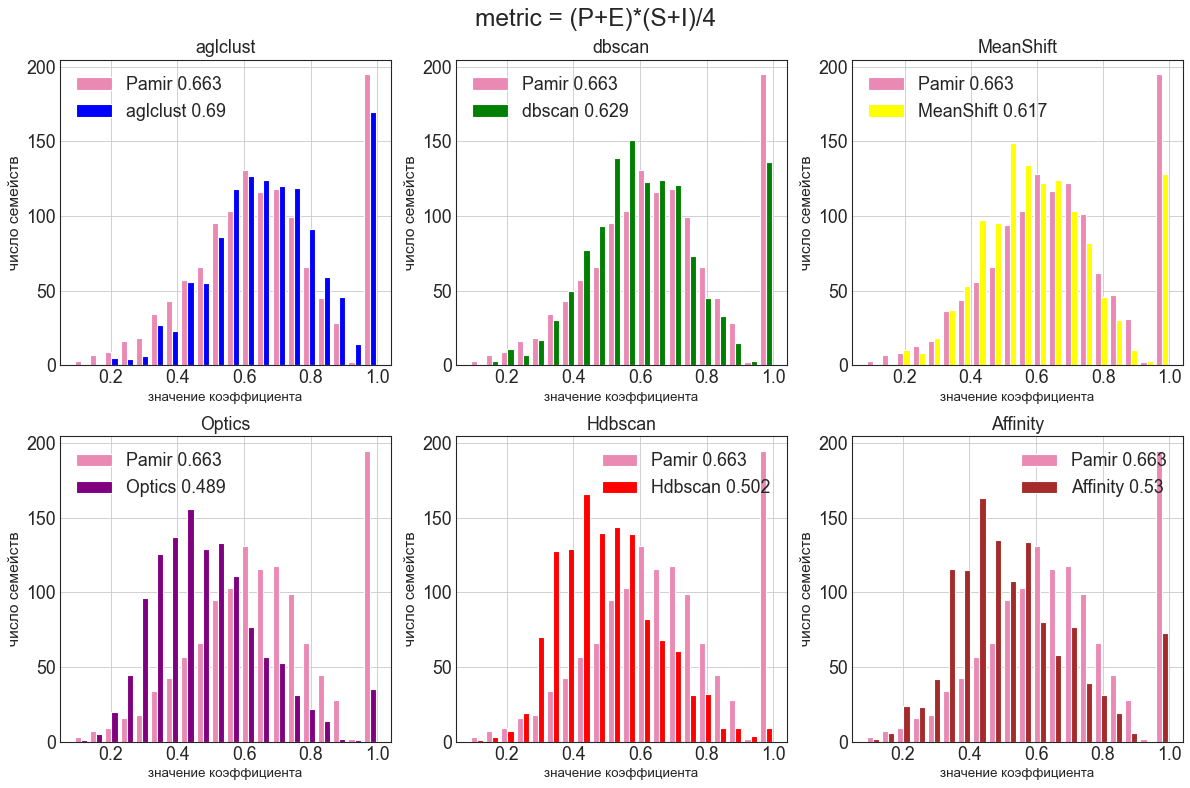

In [7]:
histogram_mpltlib(part_all,'C', 'metric = (P+E)*(S+I)/4')

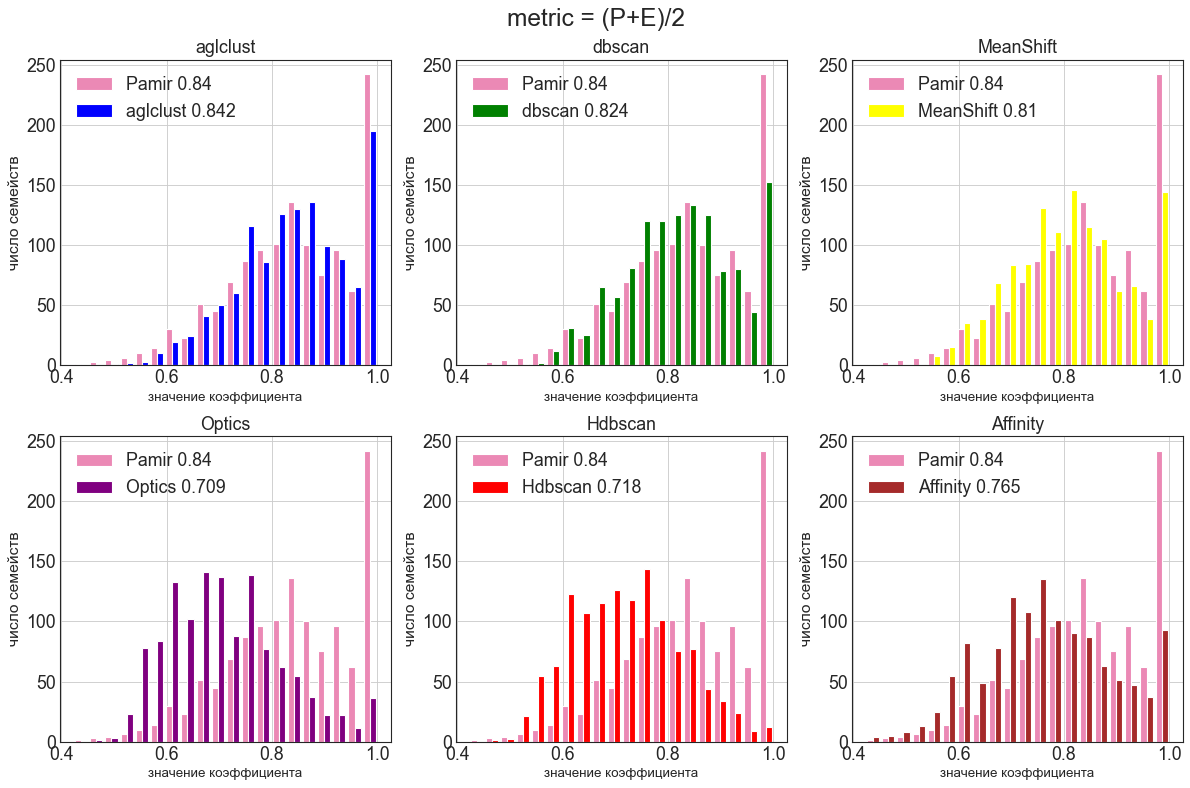

In [8]:
histogram_mpltlib(part_all, 'P+E', 'metric = (P+E)/2')

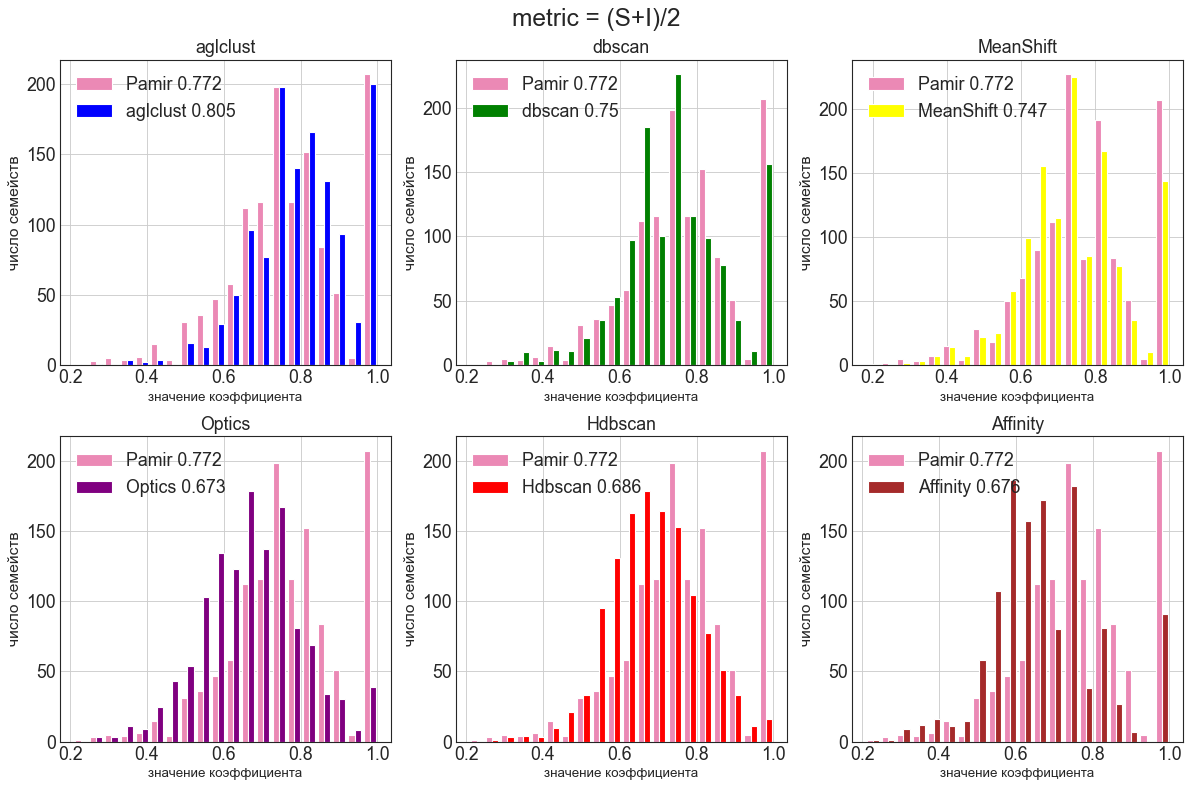

In [9]:
histogram_mpltlib(part_all, 'S+I', 'metric = (S+I)/2')

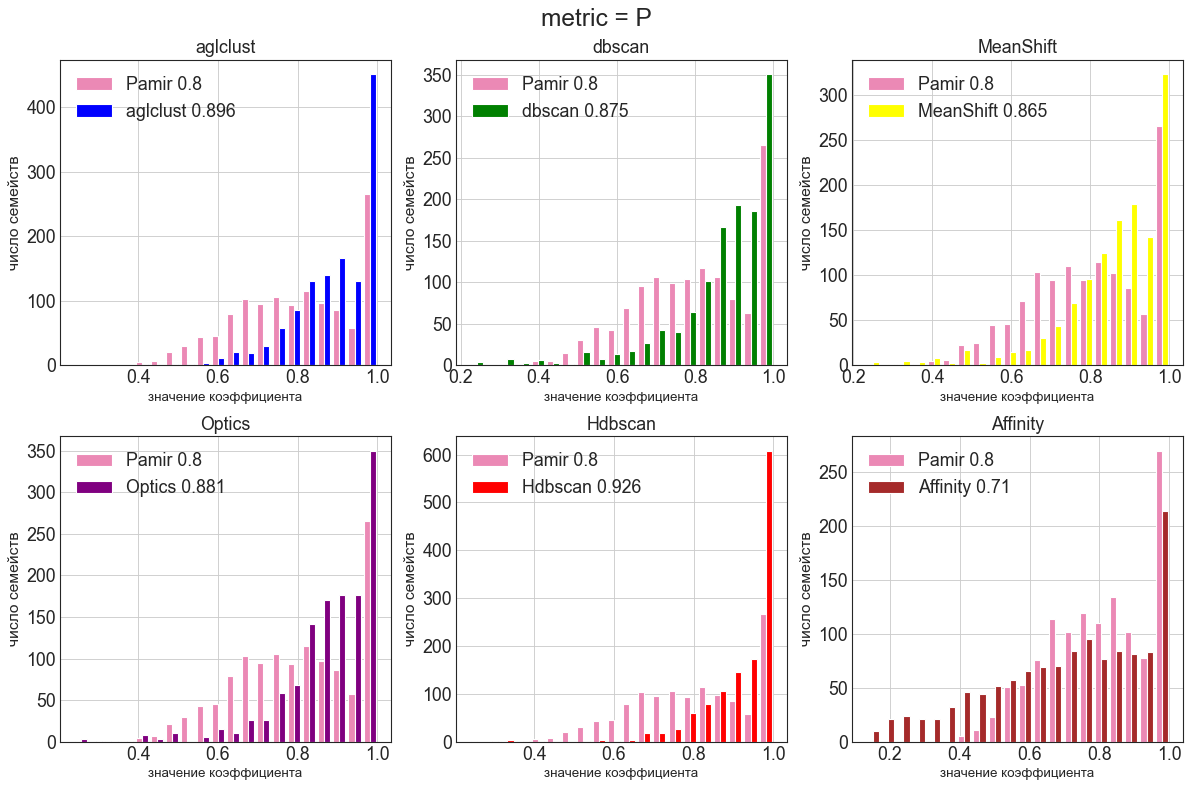

In [10]:
histogram_mpltlib(part_all, 'P', 'metric = P')

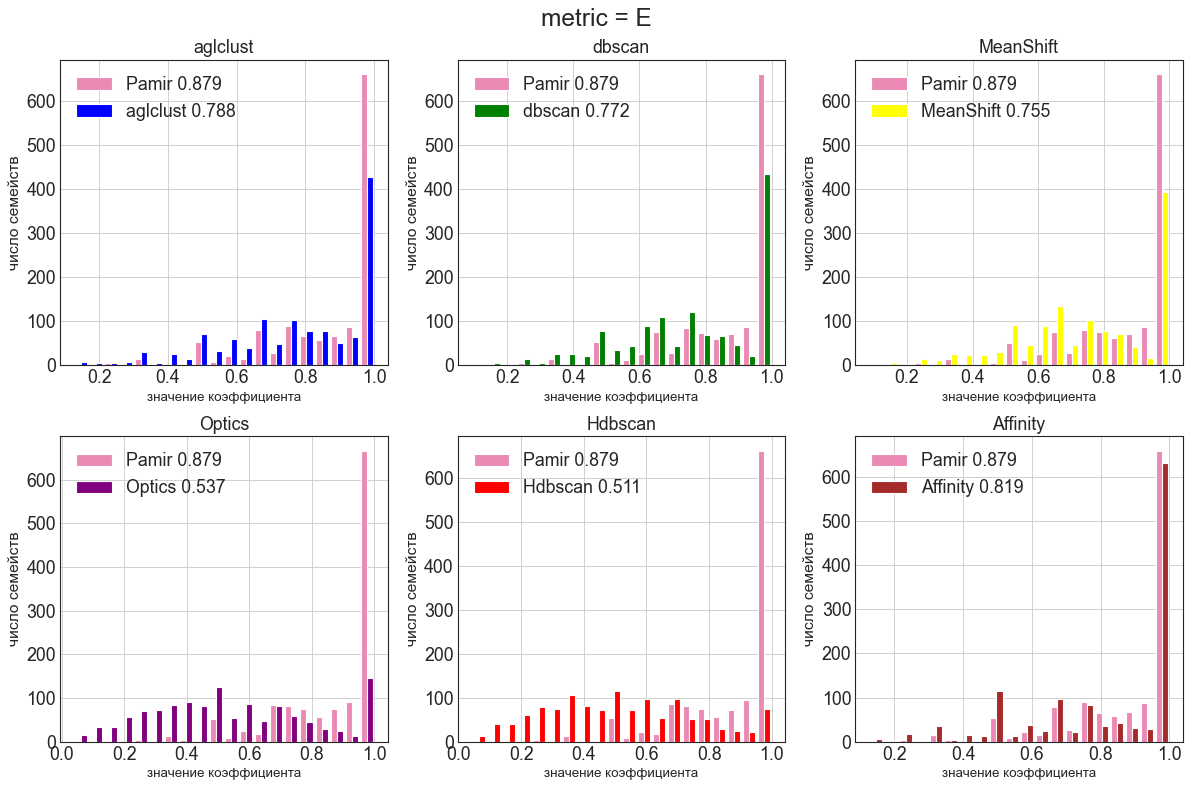

In [11]:
histogram_mpltlib(part_all, 'E', 'metric = E')

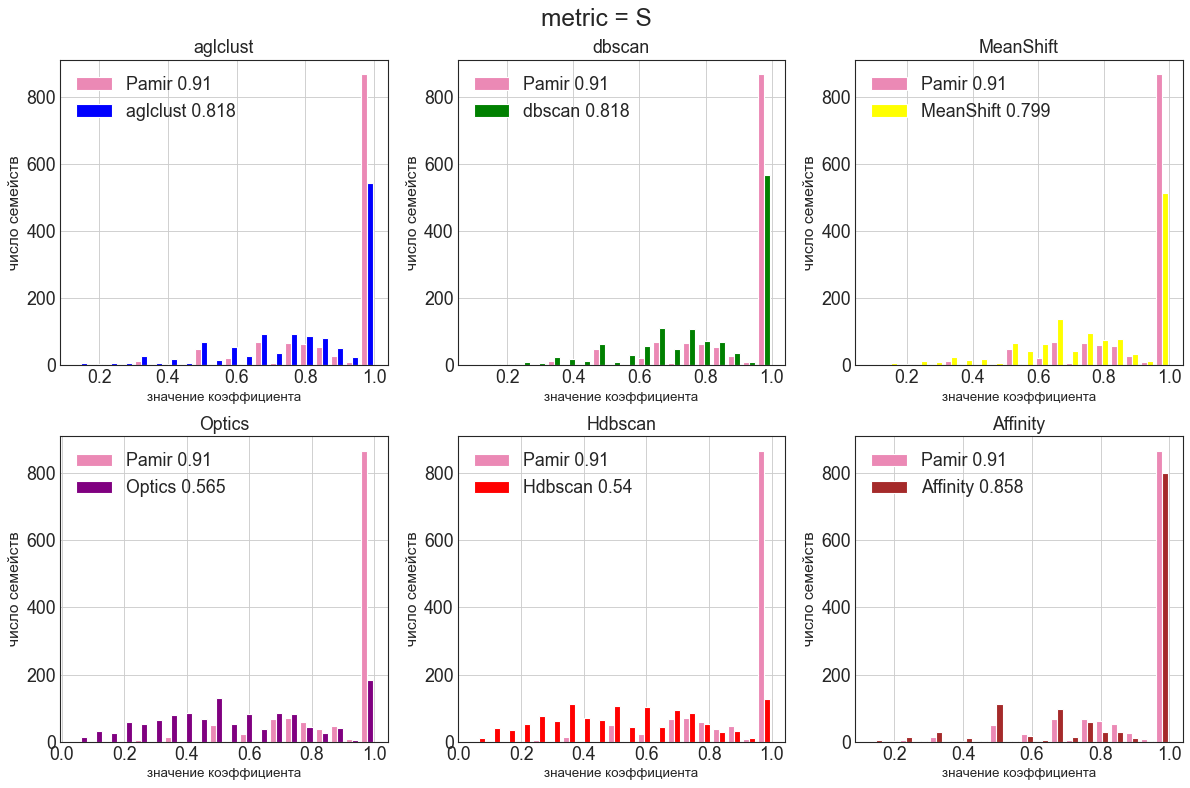

In [12]:
histogram_mpltlib(part_all, 'S', 'metric = S')

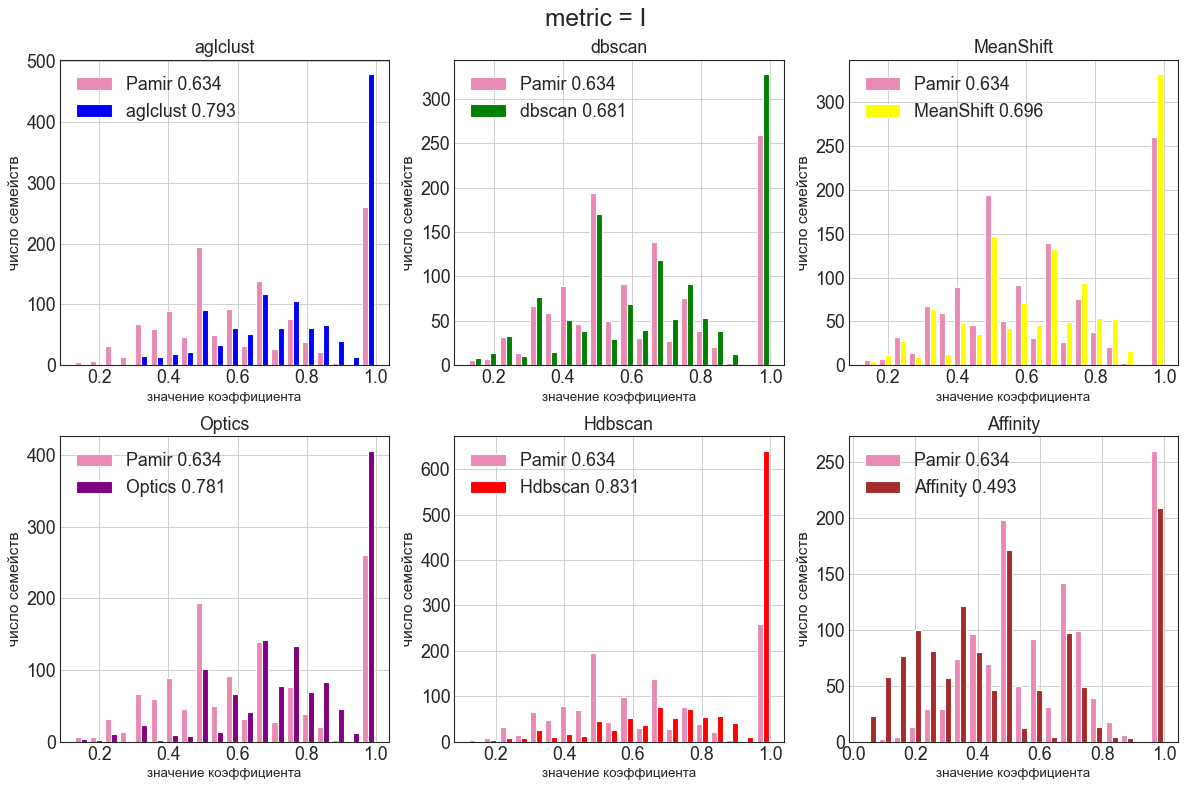

In [13]:
histogram_mpltlib(part_all, 'I', 'metric = I')

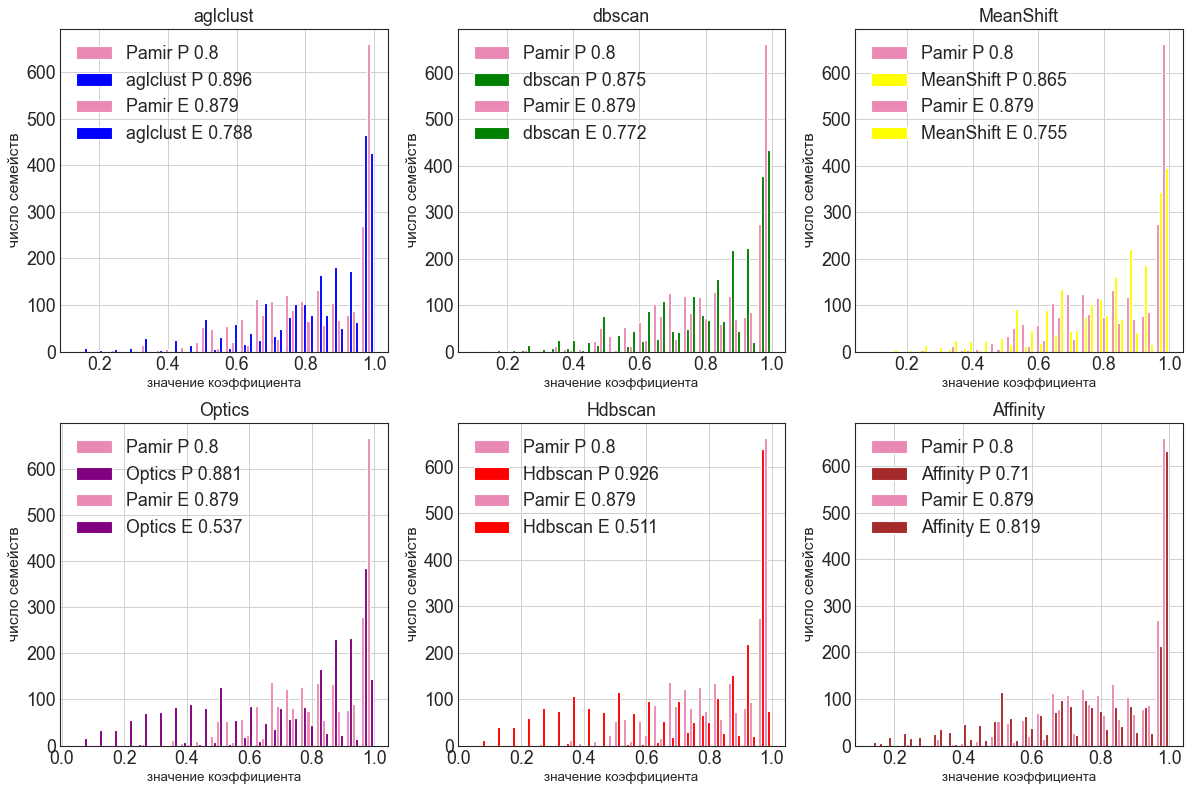

In [40]:
algorithm = ['aglclust', 'dbscan', 'MeanShift', 'Optics', 'Hdbscan', 'Affinity']
colors = ['blue', 'green', 'yellow', 'purple', 'red', 'brown']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.rcParams.update(params)

for i in range(6): 

    uniq_h_old1 = part_all[part_all['Name']==algorithm[i]]['P']
    uniq_h_exp1= part_all[part_all['Name']=='pamir']['P']
    uniq_h_old2 = part_all[part_all['Name']==algorithm[i]]['E']
    uniq_h_exp2= part_all[part_all['Name']=='pamir']['E']
        
    p1 = round(np.mean(uniq_h_old1),3)
    m1 = round(np.mean(uniq_h_exp1),3)
    p2 = round(np.mean(uniq_h_old2),3)
    m2 = round(np.mean(uniq_h_exp2),3)

    plt.subplot(2, 3, i+1)
    plt.rcParams.update(params)
    plt.title(algorithm[i])

    plt.hist([uniq_h_exp1, uniq_h_old1, uniq_h_exp2, uniq_h_old2], 
             bins = 20, 
             density = False, 
             label=[f'Pamir P {m1}', f'{algorithm[i]} P {p1}', f'Pamir E {m2}', f'{algorithm[i]} E {p2}'], 
                  color = ["#EB89B5" , colors[i], "#EB89B5" , colors[i]])
    
    plt.grid()
    plt.legend()
    plt.xlabel(f'значение коэффициента', size=12)
    plt.ylabel('число семейств', size=14)
        

plt.tight_layout()
plt.savefig(f'images/clustering_h/hist_results_P_E.png')

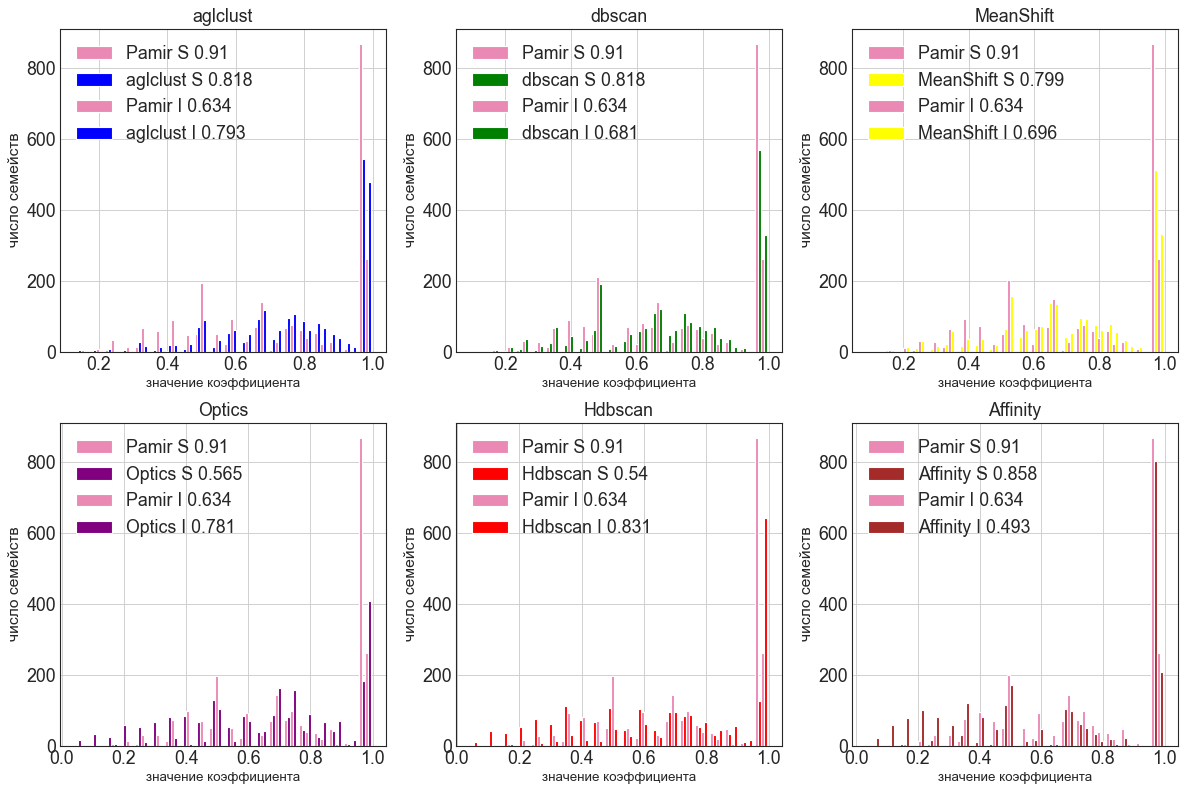

In [39]:
algorithm = ['aglclust', 'dbscan', 'MeanShift', 'Optics', 'Hdbscan', 'Affinity']
colors = ['blue', 'green', 'yellow', 'purple', 'red', 'brown']

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.rcParams.update(params)

for i in range(6): 

    uniq_h_old1 = part_all[part_all['Name']==algorithm[i]]['S']
    uniq_h_exp1= part_all[part_all['Name']=='pamir']['S']
    uniq_h_old2 = part_all[part_all['Name']==algorithm[i]]['I']
    uniq_h_exp2= part_all[part_all['Name']=='pamir']['I']
        
    p1 = round(np.mean(uniq_h_old1),3)
    m1 = round(np.mean(uniq_h_exp1),3)
    p2 = round(np.mean(uniq_h_old2),3)
    m2 = round(np.mean(uniq_h_exp2),3)

    plt.subplot(2, 3, i+1)
    plt.rcParams.update(params)
    plt.title(algorithm[i])

    plt.hist([uniq_h_exp1, uniq_h_old1, uniq_h_exp2, uniq_h_old2], 
             bins = 20, 
             density = False, 
             label=[f'Pamir S {m1}', f'{algorithm[i]} S {p1}', f'Pamir I {m2}', f'{algorithm[i]} I {p2}'], 
                  color = ["#EB89B5" , colors[i], "#EB89B5" , colors[i]])
    
    plt.grid()
    plt.legend()
    plt.xlabel(f'значение коэффициента', size=12)
    plt.ylabel('число семейств', size=14)
        

plt.tight_layout()
plt.savefig(f'images/clustering_h/hist_results_S_I.png')

In [137]:
import plotly.graph_objects as go

def fraction(x):
    return round(sum((x>0.7)*1)/len(x), 2)

def Hist(part1, coef, name, family, values):
    """
    Строит в plotly общую гистограмму распределения для выбранного коэффициента. 
    
    Входные значения:
    part1 - датафрейм, который содержит значения коэффициентов по семействам, 
    coef - тип коэффициента для гистограммы (P, S, I, E, M, C), 
    name - полное наименование коэффициента для заголовка, 
    family - тип частицы (протон, железо или др.), 
    values - параметры кластеризации.
    
    Возвращаемые значения:
    fig - фигура графика гистограммы plotly.
    """
    x0 = part1[part1['Name']=='aglclust'][coef]
    x1 = part1[part1['Name']=='dbscan'][coef]
    x2 = part1[part1['Name']=='MeanShift'][coef]
    x3 = part1[part1['Name']=='Hdbscan'][coef]
    x4 = part1[part1['Name']=='Optics'][coef]
    x5 = part1[part1['Name']=='Affinity'][coef]
    x = part1[part1['Name']=='pamir'][coef]
    
    
    legend_name = f'coef {name} <br>        mean  fraction > 0.7 \
                         <br> agl    {np.round(x0.mean(),3) }    {fraction(x0)} \
                         <br> db     { np.round(x1.mean(), 3) }   {fraction(x1)} \
                         <br> ms     { np.round(x2.mean(), 3) }   {fraction(x2)}\
                         <br> hd     { np.round(x3.mean(), 3) }   {fraction(x3)} \
                         <br> op     { np.round(x4.mean(), 3) }   {fraction(x4)} \
                         <br> af     { np.round(x5.mean(), 3) }   {fraction(x5)} \
                         <br> pam   {np.round(x.mean(), 3)}     { fraction(x)}'
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=x0, 
              #histnorm='percent',
             name='aglclust', marker_color='blue' ) )
    fig.add_trace(go.Histogram(x=x1, name = 'dbscan', marker_color='green'))
    fig.add_trace(go.Histogram(x=x2, name = 'MeanShift', marker_color='yellow'))
    fig.add_trace(go.Histogram(x=x3, name = 'Hdbscan', marker_color='purple'))
    fig.add_trace(go.Histogram(x=x4, name = 'Optics', marker_color='red'))
    fig.add_trace(go.Histogram(x=x5, name = 'Affinity', marker_color='brown'))
    
    fig.add_trace(go.Histogram(x=x, name = 'pamir', marker_color='#EB89B5'))

        
    
    fig.update_layout(
        
        title= f'{name} in {family}  and parameters {values}',
        title_font_size= 16 ,
        legend_title=legend_name,
        xaxis_title= name,
        yaxis_title='number of families',
        plot_bgcolor = 'white',
        paper_bgcolor = 'whitesmoke',
        font=dict(
            family='Verdana',
            size=12,
            color='black'),  #barmode='overlay'
        )
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.75)
    fig.write_image(f"images/web/coefficients/histogram_{coef}_{family}_{values}.png")
    fig.write_html(f"web/coefficients/histogram_{coef}_{family}_{values}.html")
    return fig

In [123]:
# Hist(part_p, 'P', 'Purity', 'Proton', val_p)
# Hist(part_p, 'S', 'Splitting', 'Proton', val_p)
# Hist(part_p, 'I', 'Integrity', 'Proton', val_p)
# Hist(part_p, 'E', 'Efficiency', 'Proton', val_p)

In [124]:
# Hist(part_f, 'P', 'Purity', 'Ferrum', val_f)
# Hist(part_f, 'S', 'Splitting', 'Ferrum', val_f)
# Hist(part_f, 'I', 'Integrity', 'Ferrum', val_f)
# Hist(part_f, 'E', 'Efficiency', 'Ferrum', val_f)

In [125]:
# Hist(part_c, 'P', 'Purity', 'MgSi', val_c)
# Hist(part_c, 'S', 'Splitting', 'MgSi', val_c)
# Hist(part_c, 'I', 'Integrity', 'MgSi', val_c)
# Hist(part_c, 'E', 'Efficiency', 'MgSi', val_c)

In [26]:
# Hist(part_all, 'P', 'Purity', 'All', val_all)
# Hist(part_all, 'S', 'Splitting', 'All', val_all)
# Hist(part_all, 'I', 'Integrity', 'All', val_all)
# Hist(part_all, 'E', 'Efficiency', 'All', val_all)

In [138]:
Hist(part_all, 'C', 'Compose', 'All', val_all)

In [133]:
part_all[part_all['Name'] == 'aglclust'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.896,0.818,0.793,0.788,0.824,0.023,0.690
std,0.105,0.206,0.199,0.208,0.112,0.029,0.183
min,0.333,0.125,0.200,0.125,0.397,0.000,0.141
25%,0.833,0.667,0.667,0.666,0.750,0.005,0.562
50%,0.917,0.857,0.800,0.814,0.825,0.014,0.679
75%,1.000,1.000,1.000,1.000,0.900,0.029,0.810
max,1.000,1.000,1.000,1.000,1.000,0.191,1.000


In [136]:
part_all[part_all['Name'] == 'pamir'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.800,0.910,0.634,0.879,0.806,0.027,0.663
std,0.151,0.158,0.234,0.164,0.130,0.025,0.205
min,0.238,0.250,0.125,0.250,0.316,0.000,0.088
25%,0.690,0.833,0.462,0.782,0.726,0.007,0.524
50%,0.807,1.000,0.600,0.981,0.810,0.020,0.649
75%,0.933,1.000,0.800,1.000,0.891,0.042,0.792
max,1.000,1.000,1.000,1.000,1.000,0.165,1.000


In [275]:
part_all[part_all['Name'] == 'dbscan'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.875,0.818,0.681,0.772,0.787,0.032,0.629
std,0.131,0.204,0.242,0.213,0.116,0.032,0.185
min,0.222,0.091,0.125,0.091,0.449,0.000,0.177
25%,0.833,0.667,0.500,0.619,0.715,0.010,0.508
50%,0.902,0.857,0.667,0.778,0.783,0.022,0.607
75%,0.969,1.000,1.000,1.000,0.851,0.044,0.721
max,1.000,1.000,1.000,1.000,1.000,0.207,1.000


In [276]:
part_all[part_all['Name'] == 'Hdbscan'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.926,0.540,0.831,0.511,0.702,0.066,0.502
std,0.098,0.254,0.211,0.237,0.102,0.055,0.147
min,0.296,0.040,0.118,0.040,0.390,0.000,0.132
25%,0.881,0.333,0.667,0.333,0.625,0.020,0.391
50%,0.955,0.500,1.000,0.500,0.700,0.049,0.490
75%,1.000,0.714,1.000,0.667,0.767,0.101,0.585
max,1.000,1.000,1.000,1.000,1.000,0.230,1.000


In [277]:
part_all[part_all['Name'] == 'Optics'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.881,0.565,0.781,0.537,0.691,0.054,0.489
std,0.119,0.264,0.195,0.256,0.116,0.052,0.167
min,0.250,0.037,0.143,0.037,0.374,0.000,0.124
25%,0.833,0.333,0.667,0.333,0.609,0.013,0.370
50%,0.900,0.542,0.778,0.500,0.683,0.039,0.467
75%,0.974,0.750,1.000,0.714,0.755,0.082,0.569
max,1.000,1.000,1.000,1.000,1.000,0.232,1.000


In [278]:
part_all[part_all['Name'] == 'MeanShift'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.865,0.799,0.696,0.755,0.779,0.031,0.617
std,0.131,0.210,0.234,0.216,0.118,0.032,0.186
min,0.231,0.083,0.133,0.083,0.316,0.000,0.082
25%,0.804,0.667,0.500,0.600,0.702,0.009,0.491
50%,0.889,0.833,0.667,0.750,0.772,0.019,0.595
75%,0.964,1.000,1.000,1.000,0.849,0.042,0.717
max,1.000,1.000,1.000,1.000,1.000,0.210,1.000


In [279]:
part_all[part_all['Name'] == 'Affinity'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

,P,S,I,E,M,V,C
count,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000,1251.000
mean,0.710,0.858,0.493,0.819,0.720,0.062,0.530
std,0.226,0.216,0.288,0.221,0.125,0.050,0.186
min,0.130,0.125,0.029,0.125,0.351,0.000,0.116
25%,0.554,0.714,0.250,0.667,0.638,0.020,0.402
50%,0.746,1.000,0.444,0.974,0.707,0.047,0.497
75%,0.900,1.000,0.667,1.000,0.796,0.098,0.629
max,1.000,1.000,1.000,1.000,1.000,0.213,1.000


In [134]:
# part_all[part_all['Name'] == 'previous'][['P', 'S', 'I', 'E', 'M', 'V', 'C']].describe().round(3)

### Построение дендрограммы для алгоритма dbscan

In [307]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

In [306]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram
    create the counts of samples under each node
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [308]:
etalon = 518
i = 518
OneFamily = AllMc0[AllMc0[' num_of_family']==i].copy()
labels = LabelEncoder().fit_transform(OneFamily['H(J)'])
OneFamily['labels'] = labels

In [309]:
val_f = [10, 80, 80]

In [310]:
X = Matrix_of_Distance(OneFamily['X(J)'].values, OneFamily['Y(J)'].values, OneFamily['E(J)'].values, 2)

In [311]:
eps1 = np.percentile(OneFamily['ER'], 10)
eps2 = np.percentile(OneFamily['ER'], 30)

In [312]:
eps3 = np.percentile(OneFamily['ER'], 80)

In [313]:
eps3

71.20747434380128

In [314]:
from sklearn.cluster import AgglomerativeClustering

db = AgglomerativeClustering(n_clusters=None, affinity = 'precomputed', distance_threshold = eps3, linkage = 'average').fit(X)
labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
OneFamily['cluster'] = labels    
print('Aglclust')
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print('Number of H: ', H)

Aglclust
Estimated number of clusters: 3
Estimated number of noise points: 0


In [315]:
dataAgl = CoefPFI(OneFamily, i)
print('eps1')
print(np.around(dataAgl[1:5], 3) )

eps1
[0.778 1.    0.429 1.   ]


In [316]:
dataAgl = CoefPFI(OneFamily, i)
print('eps2')
print(np.around(dataAgl[1:5], 3) )

eps2
[0.778 1.    0.429 1.   ]


In [317]:
dataAgl = CoefPFI(OneFamily, i)
print('eps3')
print(np.around(dataAgl[1:5], 3) )

eps3
[0.778 1.    0.429 1.   ]


<Figure size 504x504 with 0 Axes>

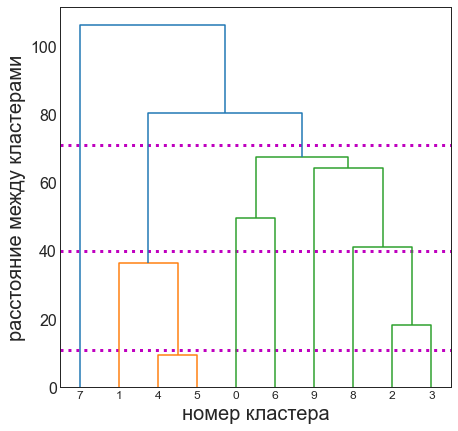

In [320]:
plt.figure(figsize=(7, 7))
fig, ax = plt.subplots(figsize=(7, 7))
ax.hlines(round(eps1), 0 ,100,
          color = 'm',
          linewidth = 3,
          linestyle = ':')
ax.hlines(round(eps2), 0 ,100,
          color = 'm',
          linewidth = 3,
          linestyle = ':')

ax.hlines(round(eps3), 0 ,100,
          color = 'm',
          linewidth = 3,
          linestyle = ':')
plt.xlabel('номер кластера', size = 20)
plt.ylabel('расстояние между кластерами', size = 20)

plot_dendrogram(db)

In [321]:
db.distances_ = np.insert(db.distances_, 0, 0)

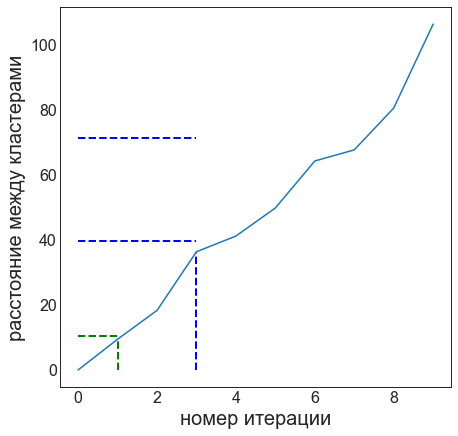

<Figure size 432x288 with 0 Axes>

In [322]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.ylabel('Distanse between merging clusters')
plt.xlabel('Merge iteration')

plt.plot(list(range(len(db.distances_))), db.distances_)

merge1 = sum((db.distances_<eps1)*1)-1
merge2 = sum((db.distances_<eps2)*1)-1

ax.vlines(merge1, 0, db.distances_[merge1],
          color = 'g',
          linewidth = 2,
          linestyle = '--')

ax.hlines(eps1, 0, merge1,
          color = 'g',
          linewidth = 2,
          linestyle = '--'
           )

ax.vlines(merge2, 0, db.distances_[merge2],
          color = 'b',
          linewidth = 2,
          linestyle = '--')

ax.hlines(eps2, 0, merge2,
          color = 'b',
          linewidth = 2,
          linestyle = '--'
           )

# ax.hlines(eps3, 0, merge2,
#           color = 'b',
#           linewidth = 2,
#           linestyle = '--'
#            )

plt.xlabel('номер итерации', size = 20)
plt.ylabel('расстояние между кластерами', size = 20)

plt.show()
plt.clf()